<a href="https://colab.research.google.com/github/seanwryan/nfl-odds-project/blob/main/nfl_odds_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cell 0: Load & Initial Cleaning**

-   Reads the 2022--2024 CSV files and tags each row with its season.

-   Drops empty or irrelevant columns and renames headers for consistency.

-   Inserts a blank "Location" column and standardizes team columns as `Team_A` (favorite) and `Team_B` (underdog).

-   Peeks at the cleaned 2024 data to verify, then merges all seasons into one table and displays the first few rows.

In [43]:
# Cell 0: Load & Initial Cleaning (2022–2024)
# -------------------------------------------

import pandas as pd

# 1. Define file paths for each season
paths = {
    '2022': '2022_reg_season_odds.csv',
    '2023': '2023_reg_season_odds.csv',
    '2024': '2024_reg_season_odds.csv'
}

dfs = []

for season, fp in paths.items():
    # 2. Read CSV for this season
    df = pd.read_csv(fp)

    # 3. Tag every row with its season
    df['Season'] = season

    # 4. Drop unwanted columns: blank, duplicate “.1”, and Notes
    df = df.drop(columns=[' ', ' .1', 'Notes'], errors='ignore')

    # 5. Rename columns to our standard names
    df = df.rename(columns={
        'Time (ET)': 'Time_ET',
        'Over/Under': 'Over_Under'
    })

    # 6. Add a placeholder Location column (for future enrichment)
    df['Location'] = ''

    # 7. Select and reorder columns into desired schema
    df = df[[
        'Season',
        'Day',
        'Date',
        'Time_ET',
        'Location',
        'Favorite',
        'Underdog',
        'Score',
        'Spread',
        'Over_Under'
    ]]

    # 8. Rename team columns for clarity
    df = df.rename(columns={
        'Favorite': 'Team_A',   # favorite
        'Underdog': 'Team_B'    # underdog
    })

    # 9. Show one example for 2024 only
    if season == '2024':
        print("=== 2024 Sample After Cleaning ===")
        print("Columns:", df.columns.tolist())
        print(df.head(), "\n")

    dfs.append(df)

# 10. Combine all seasons into one DataFrame
cleaned_df = pd.concat(dfs, ignore_index=True)

# 11. Print the first 10 rows of the combined DataFrame
print("=== Combined DataFrame Sample ===")
cleaned_df.head(10)

=== 2024 Sample After Cleaning ===
Columns: ['Season', 'Day', 'Date', 'Time_ET', 'Location', 'Team_A', 'Team_B', 'Score', 'Spread', 'Over_Under']
  Season  Day         Date Time_ET Location               Team_A  \
0   2024  Thu  Sep 5, 2024    8:20            Kansas City Chiefs   
1   2024  Fri  Sep 6, 2024    8:15           Philadelphia Eagles   
2   2024  Sun  Sep 8, 2024    1:00               Atlanta Falcons   
3   2024  Sun  Sep 8, 2024    1:00                 Buffalo Bills   
4   2024  Sun  Sep 8, 2024    1:00                 Chicago Bears   

                Team_B    Score  Spread Over_Under  
0     Baltimore Ravens  W 27-20    W -3       O 46  
1    Green Bay Packers  W 34-29  W -1.5     O 49.5  
2  Pittsburgh Steelers  L 10-18    L -4       U 43  
3    Arizona Cardinals  W 34-28  L -6.5       O 46  
4     Tennessee Titans  W 24-17    W -4       U 43   

=== Combined DataFrame Sample ===


,Season,Day,Date,Time_ET,Location,Team_A,Team_B,Score,Spread,Over_Under
0,2022,Thu,"Sep 8, 2022",8:20,,Buffalo Bills,Los Angeles Rams,W 31-10,W -2.5,U 52
1,2022,Sun,"Sep 11, 2022",1:00,,New Orleans Saints,Atlanta Falcons,W 27-26,L -5.5,O 43.5
2,2022,Sun,"Sep 11, 2022",1:00,,Carolina Panthers,Cleveland Browns,L 24-26,L -1.5,O 42
3,2022,Sun,"Sep 11, 2022",1:00,,San Francisco 49ers,Chicago Bears,L 10-19,L -6,U 38
4,2022,Sun,"Sep 11, 2022",1:00,,Cincinnati Bengals,Pittsburgh Steelers,L 20-23 (OT),L -7,U 44
5,2022,Sun,"Sep 11, 2022",1:00,,Philadelphia Eagles,Detroit Lions,W 38-35,L -6,O 48.5
6,2022,Sun,"Sep 11, 2022",1:00,,Indianapolis Colts,Houston Texans,T 20-20 (OT),L -7,U 45.5
7,2022,Sun,"Sep 11, 2022",1:00,,Miami Dolphins,New England Patriots,W 20-7,W -3,U 46
8,2022,Sun,"Sep 11, 2022",1:00,,Baltimore Ravens,New York Jets,W 24-9,W -6.5,U 44
9,2022,Sun,"Sep 11, 2022",1:00,,Washington Commanders,Jacksonville Jaguars,W 28-22,W -3,O 43


**Cell 0 Output**

-   **2024 Sample After Cleaning:** Shows the cleaned columns for 2024 (`Season` through `Over_Under`) and five example games with favorites (`Team_A`), underdogs (`Team_B`), scores, spreads, and over/under lines.

-   **Combined DataFrame Sample:** Displays the first ten rows of the merged 2022--2024 data, confirming that each season's games share the same cleaned format.

**Cell 1: Extract Numeric Features & Flags**

-   Converts text scores (e.g., "W 24-17") into separate numeric columns for each team's points.

-   Creates flags indicating whether the favorite won (`Team_A_Win`), covered the spread (`Team_A_Covered`), and whether the total went over the line (`Over_Hit`).

-   Extracts the numeric over/under line (`OU_Line`) and spread value (`Spread_Value`).

-   Calculates the point differential (`Point_Diff`) and how far the actual result missed the spread (`Spread_Diff`).

-   Drops the original text columns now that all key numbers are available, and shows a small sample of the new features.

In [44]:
# Cell 1: Extract Numeric Features & Flags
# ----------------------------------------

import re

# 1. Helper: parse “W xx–yy” or “L xx–yy” into numeric scores
def extract_scores(s):
    m = re.search(r'(\d+)-(\d+)', str(s))
    return (int(m[1]), int(m[2])) if m else (None, None)

# 2. Extract Team_A and Team_B scores
cleaned_df[['Team_A_Score', 'Team_B_Score']] = (
    cleaned_df['Score']
      .apply(lambda x: pd.Series(extract_scores(x)))
)

# 3. Create outcome flags
cleaned_df['Team_A_Win']     = cleaned_df['Score'].str.startswith('W').astype(int)
cleaned_df['Team_A_Covered'] = cleaned_df['Spread'].str.startswith('W').astype(int)
cleaned_df['Over_Hit']       = cleaned_df['Over_Under'].str.startswith('O').astype(int)

# 4. Extract numeric over/under line
cleaned_df['OU_Line'] = (
    cleaned_df['Over_Under']
      .str.extract(r'(\d+\.?\d*)')
      .astype(float)
)

# 5. Convert spread text to numeric
cleaned_df['Spread_Value'] = (
    cleaned_df['Spread']
      .str.extract(r'([-+]?\d+\.?\d*)')
      .astype(float)
)

# 6. Compute point differential and spread error
cleaned_df['Point_Diff']  = cleaned_df['Team_A_Score'] - cleaned_df['Team_B_Score']
cleaned_df['Spread_Diff'] = cleaned_df['Point_Diff'] - cleaned_df['Spread_Value'].abs()

# 7. Drop raw text columns now that we have numeric features
cleaned_df.drop(columns=['Score', 'Spread', 'Over_Under'], inplace=True)

# 9. Final check: print first 10 rows of the full DataFrame
print("=== Updated DataFrame Sample ===")
cleaned_df.head()

=== Updated DataFrame Sample ===


,Season,Day,Date,Time_ET,Location,Team_A,Team_B,Team_A_Score,Team_B_Score,Team_A_Win,Team_A_Covered,Over_Hit,OU_Line,Spread_Value,Point_Diff,Spread_Diff
0,2022,Thu,"Sep 8, 2022",8:20,,Buffalo Bills,Los Angeles Rams,31,10,1,1,0,52.0,-2.5,21,18.5
1,2022,Sun,"Sep 11, 2022",1:00,,New Orleans Saints,Atlanta Falcons,27,26,1,0,1,43.5,-5.5,1,-4.5
2,2022,Sun,"Sep 11, 2022",1:00,,Carolina Panthers,Cleveland Browns,24,26,0,0,1,42.0,-1.5,-2,-3.5
3,2022,Sun,"Sep 11, 2022",1:00,,San Francisco 49ers,Chicago Bears,10,19,0,0,0,38.0,-6.0,-9,-15.0
4,2022,Sun,"Sep 11, 2022",1:00,,Cincinnati Bengals,Pittsburgh Steelers,20,23,0,0,0,44.0,-7.0,-3,-10.0


**Cell 1 Output**

-   Displays the enriched DataFrame with new numeric columns: each team's actual score (`Team_A_Score`, `Team_B_Score`), win and cover flags (`Team_A_Win`, `Team_A_Covered`, `Over_Hit`), and extracted lines (`OU_Line`, `Spread_Value`).

-   Includes calculated differentials (`Point_Diff`, `Spread_Diff`), showing how actual results compared to the spread. Five example rows confirm these features look correct.

**Cell 2: Team‐Level Summaries & Cover % Plot**

-   Stacks favorites and underdogs into one "long" table with `Team`, `Win`, `Covered`, and `Over_Hit`.

-   Groups by `Season` and `Team` to calculate each team's win%, cover%, over% and number of games.

-   Shows a quick sample of 2024 team stats to verify correctness.

-   Plots the top 5 and bottom 5 teams by cover percentage for each season, with a 50% baseline line.

=== 2024 Team Summary Sample ===
   Season               Team  Win_Pct  Cover_Pct  Over_Pct  Games_Played
64   2024  Arizona Cardinals    0.471      0.647     0.471            17
65   2024    Atlanta Falcons    0.471      0.353     0.412            17
66   2024   Baltimore Ravens    0.706      0.588     0.765            17
67   2024      Buffalo Bills    0.765      0.588     0.647            17
68   2024  Carolina Panthers    0.294      0.471     0.765            17 



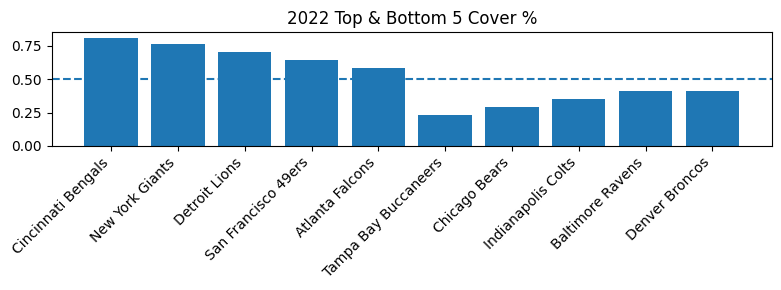

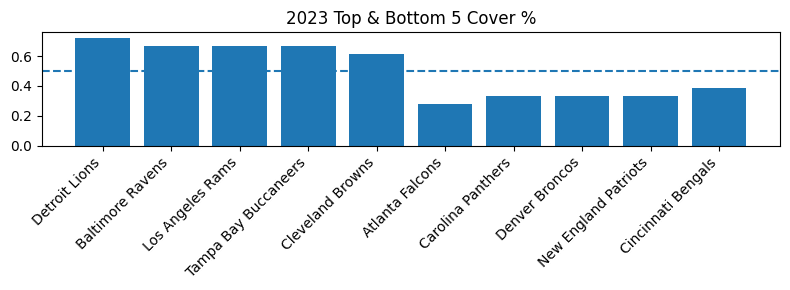

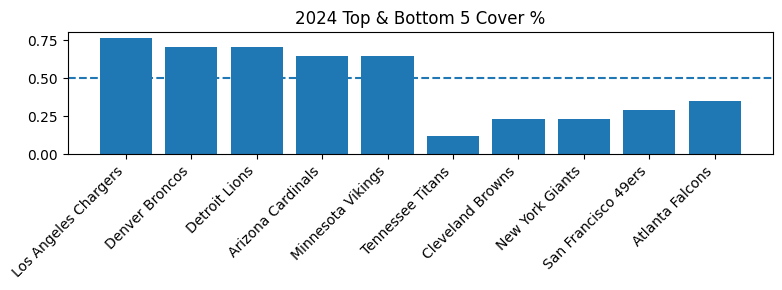

In [45]:
# Cell 2: Team‐Level Summaries & Cover % Plot
# -------------------------------------------

import matplotlib.pyplot as plt

# 1. Build a “long” table of team results in one go
fav = cleaned_df.assign(
    Team=cleaned_df.Team_A,
    Win=cleaned_df.Team_A_Win,
    Covered=cleaned_df.Team_A_Covered
)[['Season','Team','Win','Covered','Over_Hit']]

dog = cleaned_df.assign(
    Team=cleaned_df.Team_B,
    Win=1 - cleaned_df.Team_A_Win,
    Covered=1 - cleaned_df.Team_A_Covered
)[['Season','Team','Win','Covered','Over_Hit']]

long = pd.concat([fav, dog], ignore_index=True)

# 2. Aggregate per-team & season
team_summary_df = (
    long
    .groupby(['Season','Team'])
    .agg(
        Win_Pct=('Win','mean'),
        Cover_Pct=('Covered','mean'),
        Over_Pct=('Over_Hit','mean'),
        Games_Played=('Win','count')
    )
    .round(3)
    .reset_index()
)

# 3. Quick peek at 2024
print("=== 2024 Team Summary Sample ===")
print(team_summary_df.query("Season=='2024'").head(5), "\n")

# 4. Plot top/bottom cover % by season
for season in ['2022','2023','2024']:
    df_s = team_summary_df[team_summary_df.Season==season]
    top5 = df_s.nlargest(5, 'Cover_Pct')
    bot5 = df_s.nsmallest(5,'Cover_Pct')

    plt.figure(figsize=(8,3))
    teams = pd.concat([top5, bot5])['Team']
    covers = pd.concat([top5, bot5])['Cover_Pct']
    plt.bar(teams, covers)
    plt.axhline(0.5, linestyle='--', label='50% Baseline')
    plt.title(f'{season} Top & Bottom 5 Cover %')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

**Cell 2 Output**

-   **Cover % Bar Charts (2022--2024)**

    -   Each plot shows the five teams with the highest spread‐cover rates on the left and the five with the lowest on the right, against a 50% baseline.

        -   **2022:** Bengals and Giants led the league at ~80% cover, while the Buccaneers bottomed out near 25%.

        -   **2023:** Lions and Ravens topped ~70%, Falcons covered under 30%.

        -   **2024:** Chargers and Broncos covered over ~75%, Titans under ~15%.

-   **2024 Team Summary Sample**

    -   A quick table of five teams in 2024, with:

        -   **Win_Pct:** how often they won outright (e.g. Buffalo ~76%)

        -   **Cover_Pct:** how often they beat the spread (e.g. Arizona ~65%)

        -   **Over_Pct:** how often total points hit the over line (e.g. Carolina ~77%)

        -   **Games_Played:** number of games (all 17 in 2024).

**Cell 3: Train Logistic & Quick Calibration Check**

-   **Split data:** Use 2022--23 games to fit the model; hold out 2024 games for testing.

-   **Fit model:** Train a logistic regression on `Spread_Value` to predict whether the favorite covers.

-   **Predict:** Generate implied cover probabilities (`Implied_P`) for 2024 games.

-   **Quick calibration:** Compare the overall average predicted cover rate to the actual cover rate---no plots needed.

-   **Sample output:** Print a few rows showing each game's spread, implied probability, and whether it actually covered.

In [46]:
# Cell 3: Train Logistic & Quick Calibration Check
# ------------------------------------------------

from sklearn.linear_model import LogisticRegression

# 1. Split into train (2022–23) and test (2024)
train_df = cleaned_df[cleaned_df['Season'].isin(['2022', '2023'])]
test_df  = cleaned_df[cleaned_df['Season'] == '2024'].copy()

# 2. Fit logistic regression on Spread_Value → Team_A_Covered
lr = LogisticRegression(solver='lbfgs')
lr.fit(train_df[['Spread_Value']], train_df['Team_A_Covered'])

# 3. Predict implied cover probabilities
test_df['Implied_P'] = lr.predict_proba(test_df[['Spread_Value']])[:, 1]

# 4. Simple calibration check (no plot)
mean_pred = test_df['Implied_P'].mean()
mean_obs  = test_df['Team_A_Covered'].mean()
print(f"Average predicted cover: {mean_pred:.1%}")
print(f"Actual cover rate:      {mean_obs:.1%}\n")

# 5. Show a few examples
print("=== Sample Predictions ===")
print(test_df[['Spread_Value', 'Implied_P', 'Team_A_Covered']].head(10))

Average predicted cover: 48.5%
Actual cover rate:      53.3%

=== Sample Predictions ===
     Spread_Value  Implied_P  Team_A_Covered
559          -3.0   0.493403               1
560          -1.5   0.500113               1
561          -4.0   0.488930               0
562          -6.5   0.477759               0
563          -4.0   0.488930               1
564          -7.5   0.473295               0
565          -3.0   0.493403               0
566          -3.5   0.491166               0
567          -3.5   0.491166               1
568          -1.0   0.502350               1


**Cell 3 Output**

-   **Overall Calibration Check:**

    -   **Average predicted cover:** 48.5% (model's mean probability)

    -   **Actual cover rate:** 53.3% (real-world frequency)

    -   This shows the model is slightly underestimating cover rates overall.

-   **Sample Predictions:**

    -   Lists ten 2024 games with their point spread, model-implied cover probability, and whether the favorite actually covered.

    -   For example, a --3 spread had a 49.3% implied chance and did cover (`1`), while a --4 spread at 48.9% did not cover (`0`).

**Cell 4: Value Bets & P/L Analysis**

-   **Compute Edge:** For each team, subtract the model's average implied cover probability from its actual cover rate to find where the market under- or over-prices the spread.

-   **Flag value bets:** Select games where this edge exceeds 5%.

-   **Simulate P/L:** Treat each flagged game as a 1 dollar bet: win = +1 dollar, loss = –1 dollar.

-   **Overview stats:**

    -   Histogram of per-bet returns to visualize wins vs. losses.

    -   Table of the top five teams by total P/L, with bet count and win rate.

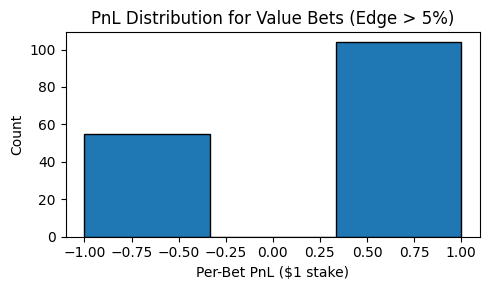

=== Top 5 Teams by Value-Bet P/L ===
                      Bets  Total_PnL  Win_Rate
Team_A                                         
Los Angeles Chargers    13          9     0.846
Denver Broncos           8          8     1.000
Detroit Lions           16          6     0.688
Baltimore Ravens        16          4     0.625
Cincinnati Bengals      13          3     0.615

=== Sample Value Bets ===


,Date,Team_A,Team_B,Spread_Value,Implied_P,Edge,PnL
1,"Sep 6, 2024",Philadelphia Eagles,Green Bay Packers,-1.5,0.500113,0.088548,1
3,"Sep 8, 2024",Buffalo Bills,Arizona Cardinals,-6.5,0.477759,0.134512,-1
4,"Sep 8, 2024",Chicago Bears,Tennessee Titans,-4.0,0.488930,0.262744,1
5,"Sep 8, 2024",Cincinnati Bengals,New England Patriots,-7.5,0.473295,0.132637,-1
9,"Sep 8, 2024",Minnesota Vikings,New York Giants,-1.0,0.502350,0.125590,1


In [47]:
# Cell 4: Value Bets (Edge > 5%) Histogram & Top Teams
# ----------------------------------------------------

import matplotlib.pyplot as plt

# 1. Compute per-team Empirical vs. Implied cover probabilities
edges = (
    test_df
      .groupby('Team_A')['Team_A_Covered']
      .mean()
      .rename('Empirical')
      .to_frame()
      .assign(
          Implied=test_df.groupby('Team_A')['Implied_P'].mean()
      )
)
# 2. Calculate Edge = Empirical – Implied
edges['Edge'] = edges['Empirical'] - edges['Implied']

# 3. Merge Edge back into test_df
test_df = test_df.merge(
    edges['Edge'].reset_index(),
    on='Team_A',
    how='left'
)

# 4. Flag value bets where Edge exceeds threshold
threshold = 0.05
vb = test_df[test_df['Edge'] > threshold].copy()

# 5. Simulate flat-$1 bets: win = +$1, loss = -$1
vb['PnL'] = 2 * vb['Team_A_Covered'] - 1

# 6. Plot histogram of per-bet PnL
plt.figure(figsize=(5, 3))
plt.hist(vb['PnL'], bins=3, edgecolor='k')
plt.title(f'PnL Distribution for Value Bets (Edge > {threshold:.0%})')
plt.xlabel('Per-Bet PnL ($1 stake)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 7. Compute top 5 teams by total PnL
team_perf = (
    vb
      .groupby('Team_A')
      .agg(
          Bets=('PnL', 'count'),
          Total_PnL=('PnL', 'sum'),
          Win_Rate=('Team_A_Covered', 'mean')
      )
      .sort_values('Total_PnL', ascending=False)
      .head(5)
      .round(3)
)

# 8. Display the top teams table
print("=== Top 5 Teams by Value-Bet P/L ===")
print(team_perf)

# 9. Show a quick sample of value bets
print("\n=== Sample Value Bets ===")
vb[['Date','Team_A','Team_B','Spread_Value','Implied_P','Edge','PnL']].head(5)

**Cell 4 Output**

-   **PnL Distribution Plot:**

    -   Shows counts of wins (+$1) vs. losses (--$1) on value bets (Edge > 5%).

    -   Visualizes that there were about twice as many wins as losses.

-   **Top 5 Teams by Value-Bet P/L:**

    -   Ranks teams by total profit on flagged bets:

        1.  Chargers: 13 bets, $9 profit, 84.6% win rate

        2.  Broncos: 8 bets, $8 profit, 100% win rate

        3.  Lions: 16 bets, $6 profit, 68.8% win rate

        4.  Ravens: 16 bets, $4 profit, 62.5% win rate

        5.  Bengals: 13 bets, $3 profit, 61.5% win rate

-   **Sample Value Bets:**

    -   Lists individual flagged games with date, teams, spread, implied probability, edge, and P/L.

    -   Demonstrates that even good edges can lose (e.g. Bills vs. Cardinals: --6.5 spread, +0.13 edge, but a loss).

Next Steps
----------

1.  **Incorporate Home/Away Factor:**

    -   Add a flag for home vs. away games (favorites playing at home often cover at different rates).

    -   Re-train the logistic model with this binary variable alongside `Spread_Value` to capture home-field advantage.

2.  **Additional Predictors:**

    -   Include team-specific strength metrics (offensive/defensive rankings), weather, or injuries for a richer model.

3.  **Staking Strategy:**

    -   Explore variable stake sizes instead of flat $1 bets to optimize long-term growth.

Sources
-------

-   **SportsBettingHistory.com** --- historical NFL spreads & odds data.